https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

这个简单的MLP模型中，输入的图像首先被flatten为一个向量。这种简单粗暴的处理丢失了像素之间的空间关系，后续的CNN和Attention较好解决了这个问题。

model is on: cuda:0



(dot.exe:28956): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


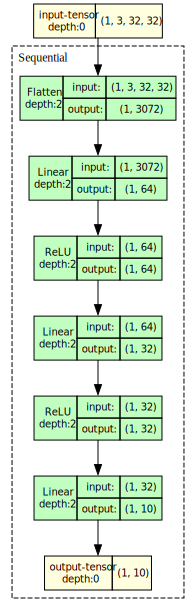

In [2]:
from torchview import draw_graph


device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlp = MLP().to(device)

print('model is on:', next(mlp.parameters()).device)

batch_size = 1
model_graph = draw_graph(mlp, input_size=(batch_size, 3, 32, 32), expand_nested=True) # device='meta', 
model_graph.visual_graph

## CIFAR 10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

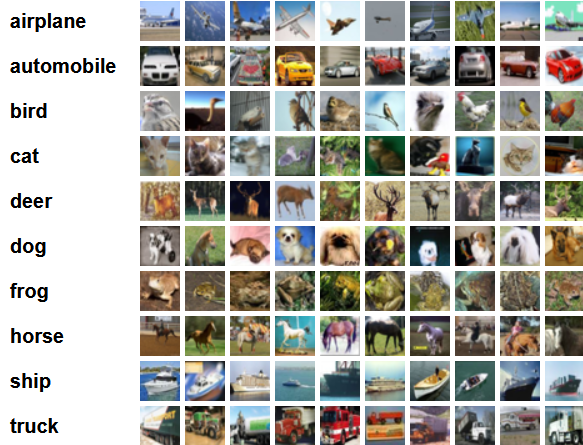

In [3]:
# Prepare CIFAR-10 dataset
from torchvision.datasets import CIFAR10, CIFAR100

dataset = CIFAR10("../data/", download=True, transform=transforms.ToTensor()) # os.getcwd()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)

Files already downloaded and verified


pyTorch中的dataset类型（包括各种内置公开数据集和ImageFolder等返回的数据集对象），具有`classes`和`class_to_idx`两个属性，可以方便得到类别名称和字典

In [4]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

几个概念的解释：  
loss function，optimizer，epoch，backward

In [6]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
mlp.train()

# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0

    corrects = 0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        inputs, targets = data
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == targets.data)
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0
            
    print('acc =', corrects.double().item() / len(dataset))

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 2.207
Loss after mini-batch  1000: 2.047
Loss after mini-batch  1500: 1.967
Loss after mini-batch  2000: 1.922
Loss after mini-batch  2500: 1.902
Loss after mini-batch  3000: 1.880
acc = 0.27824
Starting epoch 2
Loss after mini-batch   500: 1.852
Loss after mini-batch  1000: 1.834
Loss after mini-batch  1500: 1.816
Loss after mini-batch  2000: 1.814
Loss after mini-batch  2500: 1.820
Loss after mini-batch  3000: 1.807
acc = 0.3543
Starting epoch 3
Loss after mini-batch   500: 1.787
Loss after mini-batch  1000: 1.779
Loss after mini-batch  1500: 1.761
Loss after mini-batch  2000: 1.750
Loss after mini-batch  2500: 1.734
Loss after mini-batch  3000: 1.744
acc = 0.37858
Starting epoch 4
Loss after mini-batch   500: 1.716
Loss after mini-batch  1000: 1.722
Loss after mini-batch  1500: 1.710
Loss after mini-batch  2000: 1.692
Loss after mini-batch  2500: 1.697
Loss after mini-batch  3000: 1.695
acc = 0.39734
Starting epoch 5
Loss after mini-batc

在10分类问题上得到> 40% acc  
后续改进方向：conv，imshow